# LeNet Lab
This document contains Traffic Signs Classifier lab with usage of LeNet architecture. This solution is implemented with usage of TensorFlow framework.

### Imports

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import numpy as np
import pickle
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import os
import matplotlib.image as mpimg

# Helper functions
Some helper functions
### Get traffic sign description by id

In [22]:
sign_names = pd.read_csv('./signnames.csv').values
def get_sign_name(id):
    for sign in sign_names:
        if (sign[0] == id):
            return sign[1] 

### Plot preview of the images

In [23]:
%matplotlib inline
def print_examples_from_group(images, ids, grayscale = False):
    line_length = 17
    
    for sign in sign_names:
        lane = plt.figure(figsize = (line_length, 1))
        lane.subplots_adjust(hspace = 0, wspace = 0)
        
        print("Id: {0}, name: {1}".format(sign[0], sign[1]))
        sign_ids = np.where(ids==sign[0])[0]
        for i in range(line_length):
            index = randint(0, sign_ids.size - 1)
            image = images[sign_ids[index]]
            a = lane.add_subplot(1, line_length, i + 1, xticks=[], yticks=[])
            if (grayscale):
                a.imshow(image.squeeze(), cmap = "gray")
            else:
                a.imshow(image.squeeze())
        plt.show()

# Load Data
First of all lets load and preview the data.

In [24]:
training_file = "train.p"
validation_file = "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_init, y_train = train['features'], train['labels']
X_valid_init, y_valid = valid['features'], valid['labels']
X_test_init, y_test = test['features'], test['labels']

assert(len(X_train_init) == len(y_train))
assert(len(X_valid_init) == len(y_valid))
assert(len(X_test_init) == len(y_test))

print()
print("Image Shape: {}".format(X_train_init[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train_init)))
print("Validation Set: {} samples".format(len(X_valid_init)))
print("Test Set:       {} samples".format(len(X_test_init)))  


Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples


Show amount of images for each traffic sign from train set. It is important to understand if there is enough train images for a sign in case of bad model performance.

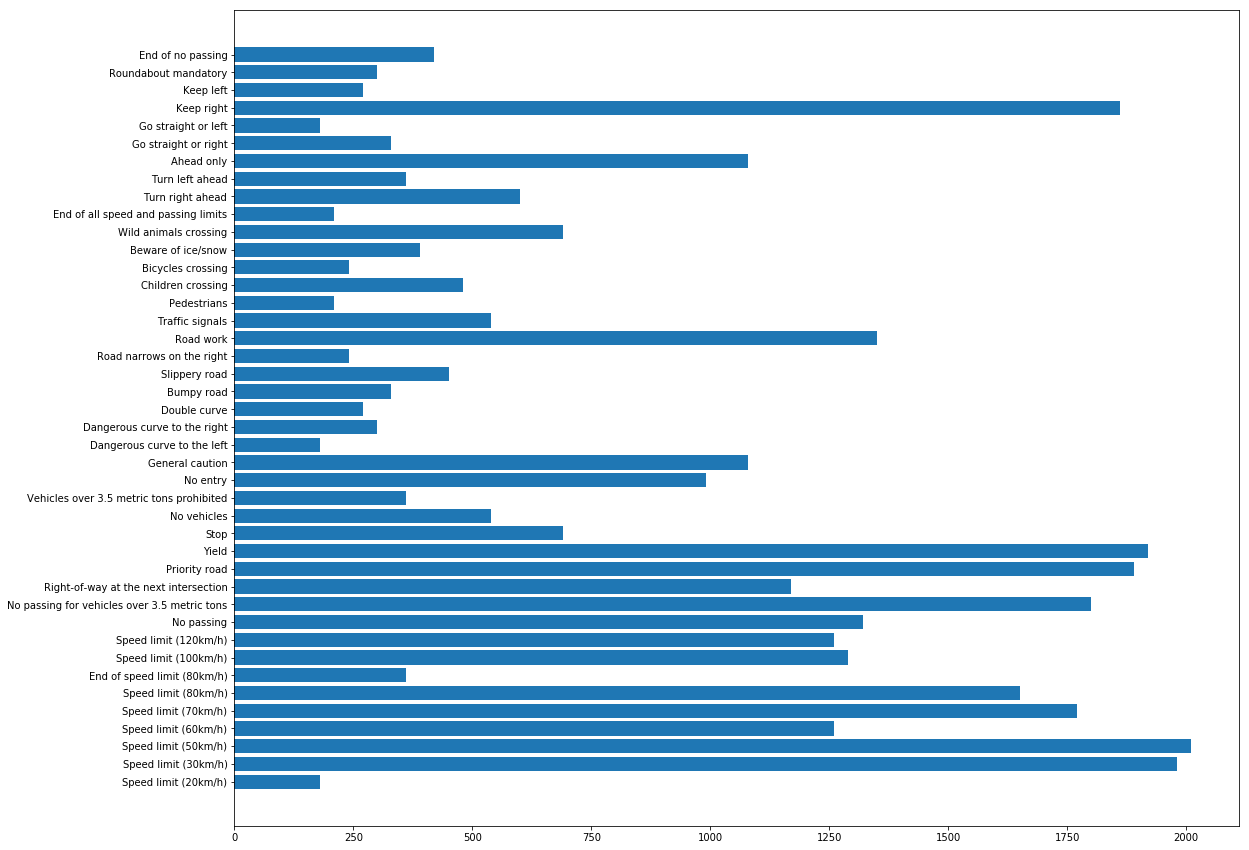

In [25]:
hist, bins = np.histogram(y_train, bins=42)
plt.figure(figsize=(18, 15))
x_pos = [i for i, _ in enumerate(hist)]
plt.barh(x_pos, hist)
labs=[get_sign_name(j) for j in bins]
plt.yticks(x_pos, labs)
plt.show()

Show preview of the images

Id: 0, name: Speed limit (20km/h)


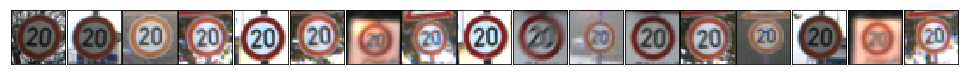

Id: 1, name: Speed limit (30km/h)


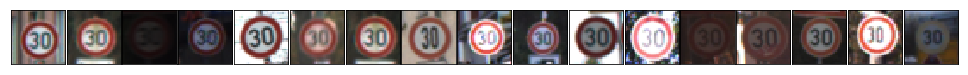

Id: 2, name: Speed limit (50km/h)


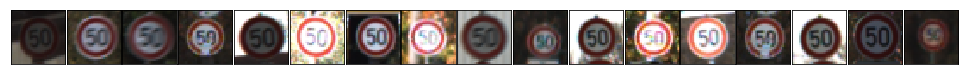

Id: 3, name: Speed limit (60km/h)


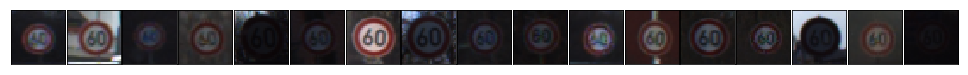

Id: 4, name: Speed limit (70km/h)


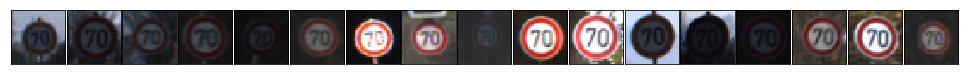

Id: 5, name: Speed limit (80km/h)


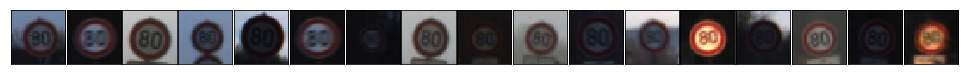

Id: 6, name: End of speed limit (80km/h)


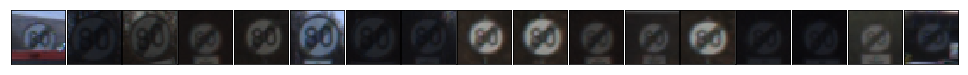

Id: 7, name: Speed limit (100km/h)


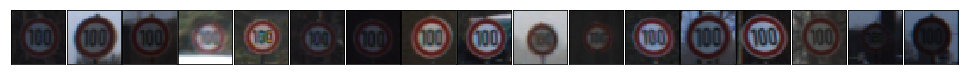

Id: 8, name: Speed limit (120km/h)


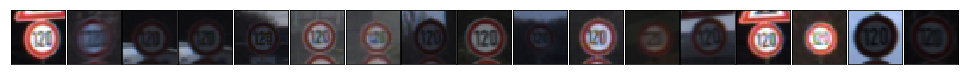

Id: 9, name: No passing


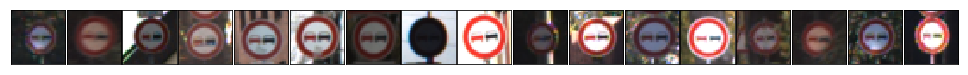

Id: 10, name: No passing for vehicles over 3.5 metric tons


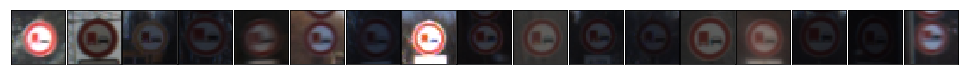

Id: 11, name: Right-of-way at the next intersection


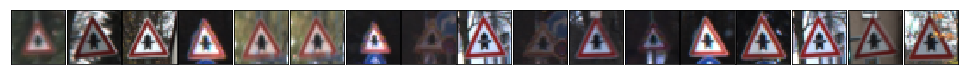

Id: 12, name: Priority road


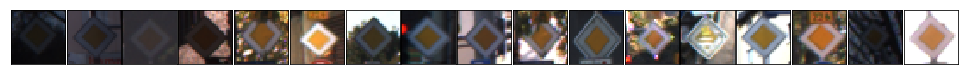

Id: 13, name: Yield


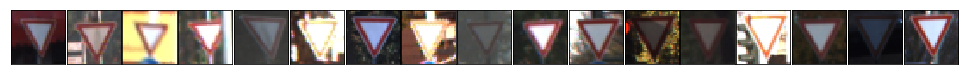

Id: 14, name: Stop


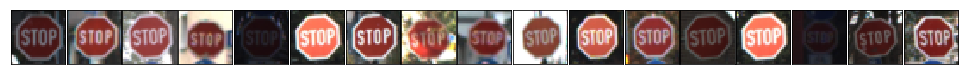

Id: 15, name: No vehicles


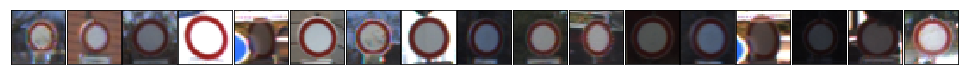

Id: 16, name: Vehicles over 3.5 metric tons prohibited


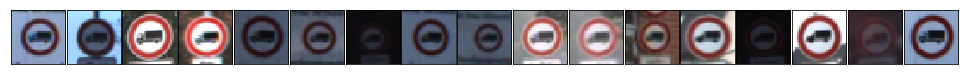

Id: 17, name: No entry


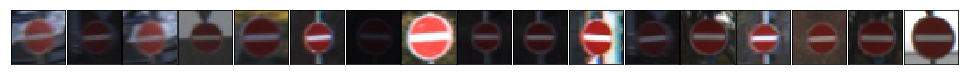

Id: 18, name: General caution


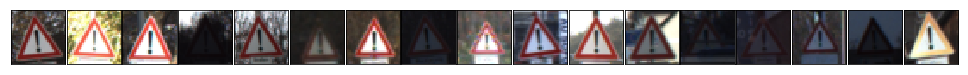

Id: 19, name: Dangerous curve to the left


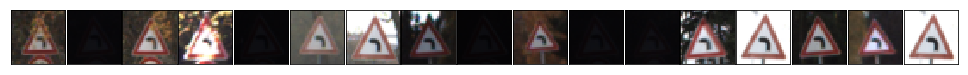

Id: 20, name: Dangerous curve to the right


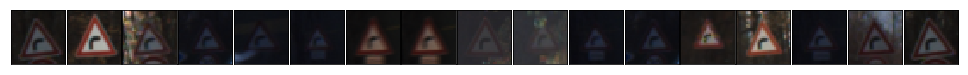

Id: 21, name: Double curve


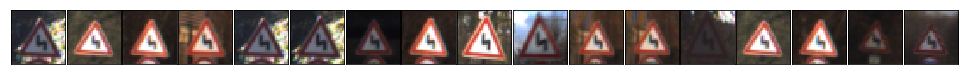

Id: 22, name: Bumpy road


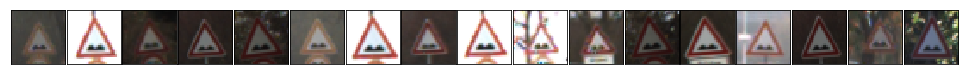

Id: 23, name: Slippery road


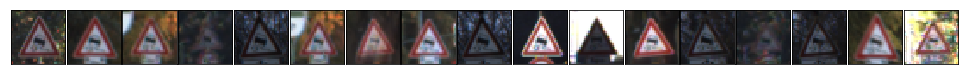

Id: 24, name: Road narrows on the right


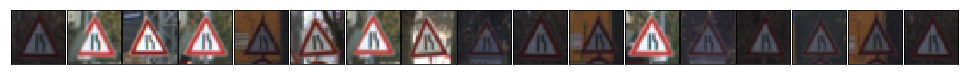

Id: 25, name: Road work


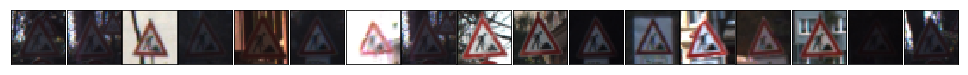

Id: 26, name: Traffic signals


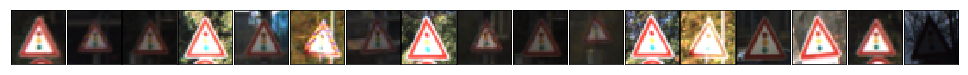

Id: 27, name: Pedestrians


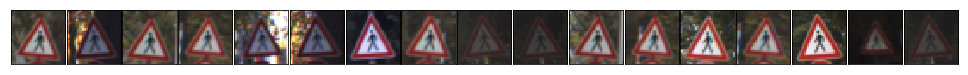

Id: 28, name: Children crossing


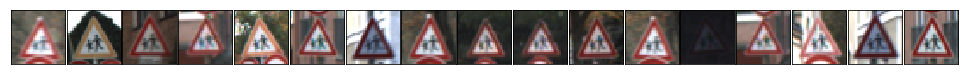

Id: 29, name: Bicycles crossing


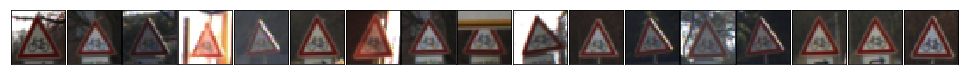

Id: 30, name: Beware of ice/snow


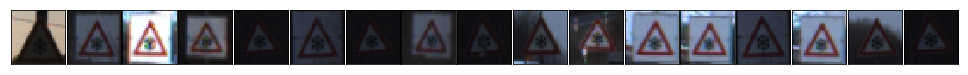

Id: 31, name: Wild animals crossing


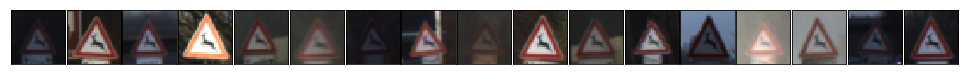

Id: 32, name: End of all speed and passing limits


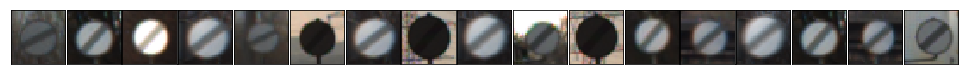

Id: 33, name: Turn right ahead


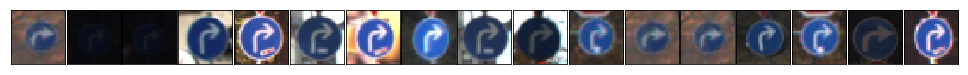

Id: 34, name: Turn left ahead


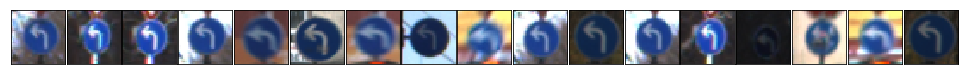

Id: 35, name: Ahead only


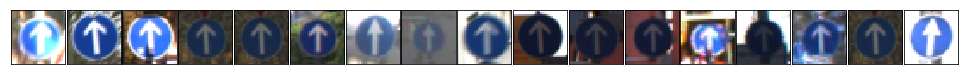

Id: 36, name: Go straight or right


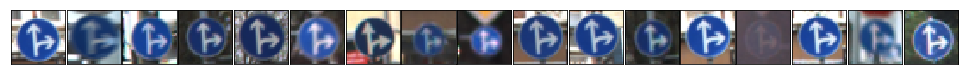

Id: 37, name: Go straight or left


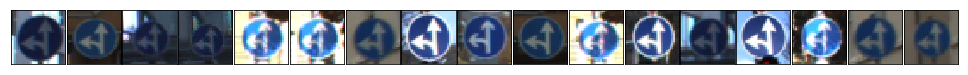

Id: 38, name: Keep right


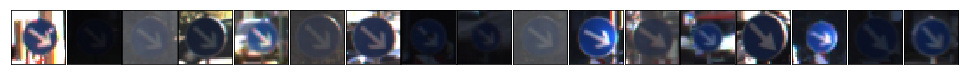

Id: 39, name: Keep left


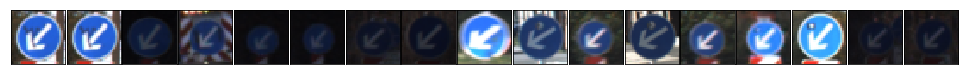

Id: 40, name: Roundabout mandatory


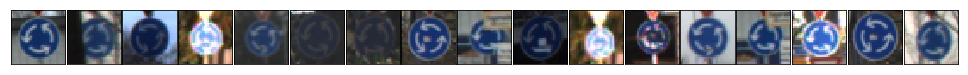

Id: 41, name: End of no passing


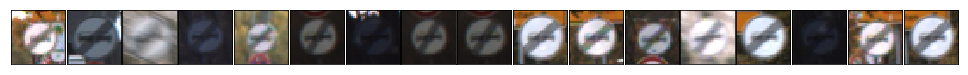

Id: 42, name: End of no passing by vehicles over 3.5 metric tons


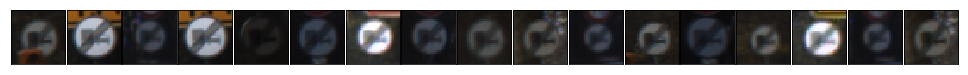

In [26]:
print_examples_from_group(X_train_init, y_train)

# Images preprocessing
After images preview we can see that they are taken in different conditions (day, night, snow, with and without light reflection). On some images it is even hard to recognise the sign without preprocessing. If we train the model on this images without any preprocessing, model will give us just around 60% accuracy. So, there should be some preprocessing done for them. I tried several methods and came up with following preprocessing strategy:

1. Grayscale images. Intuition says, that color images has more data and model should work better on them, but if I train the model with grayscale images, it performs much better.
2. Some images are too dark, some are too light, so it will help a lot if we perform some lightning normalisation. I decided to stop on histogram equalisation. Images after this steps train model better, but there is still space to improve by applying of different algorithms and noise reduction.
3. General normalisation of the data to have center in 0. This method does not change an image at all, but has significant effect on the training process.

There is also space for image augmentation: image rotating and transformation, but it should be performed in some intelligent way and not for all images — what will improve one image can "kill" another. So, there should be some image preprocessing, for example, recognition of sign shape and transforming it to normal. We can also try to use information of where on the image is the sign and how far is it, so we could know what transformation should be done to make shape normal. So far I did not apply any image augmentation because images in the test dataset are very different and different types of augmentation should be applied to different images.

Also, cropping of the images to sign size could help the network to learn.

In [27]:
def grayscale_image(img):
    gs = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    return np.resize(gs[:,:,0], (32,32,1))

def equalise_histogram(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    return cdf[img]

def normalise_image(img):
    return img/256 - 0.5

def preprocess_images(imgs):
    res = []
    for img in imgs:
        gs = grayscale_image(img)
        eq = equalise_histogram(gs)
        nm = normalise_image(eq)
        res.append(nm)
    return res    

In [28]:
X_train = preprocess_images(X_train_init)
X_valid = preprocess_images(X_valid_init)
X_test = preprocess_images(X_test_init)

Preview images after preprocessing

Id: 0, name: Speed limit (20km/h)


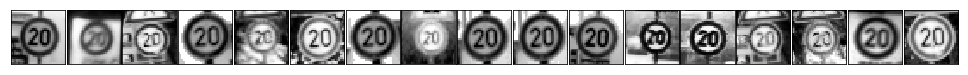

Id: 1, name: Speed limit (30km/h)


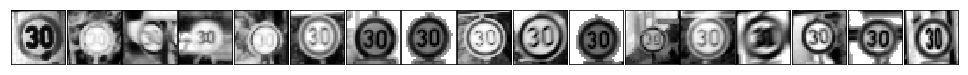

Id: 2, name: Speed limit (50km/h)


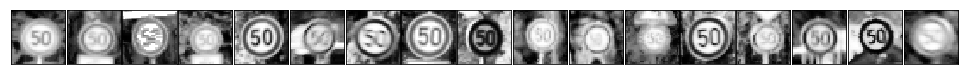

Id: 3, name: Speed limit (60km/h)


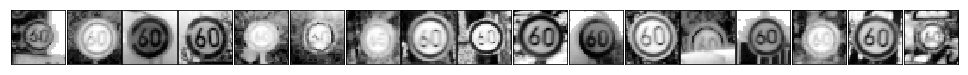

Id: 4, name: Speed limit (70km/h)


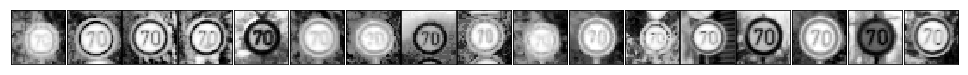

Id: 5, name: Speed limit (80km/h)


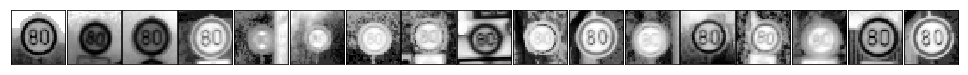

Id: 6, name: End of speed limit (80km/h)


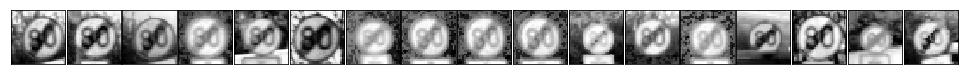

Id: 7, name: Speed limit (100km/h)


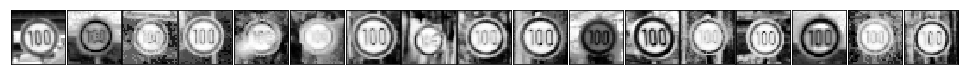

Id: 8, name: Speed limit (120km/h)


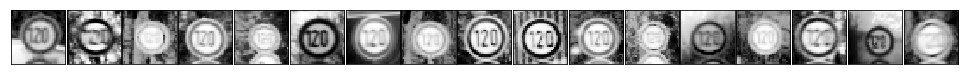

Id: 9, name: No passing


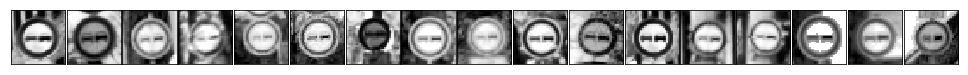

Id: 10, name: No passing for vehicles over 3.5 metric tons


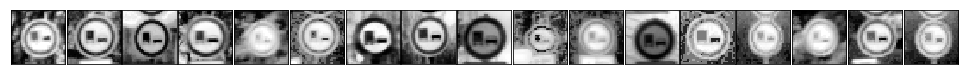

Id: 11, name: Right-of-way at the next intersection


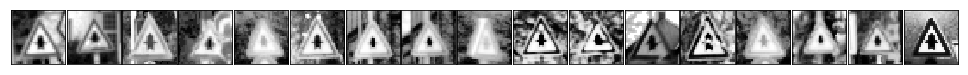

Id: 12, name: Priority road


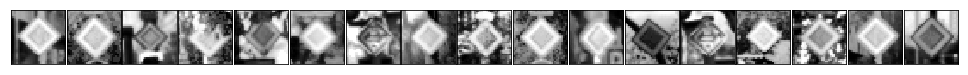

Id: 13, name: Yield


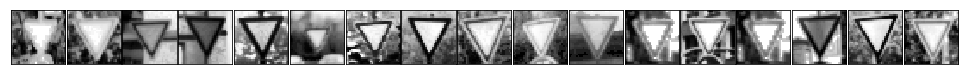

Id: 14, name: Stop


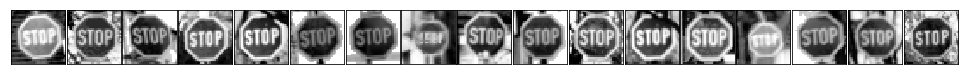

Id: 15, name: No vehicles


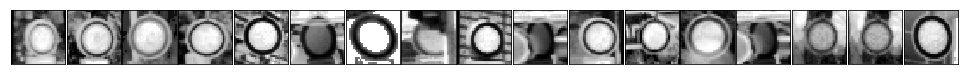

Id: 16, name: Vehicles over 3.5 metric tons prohibited


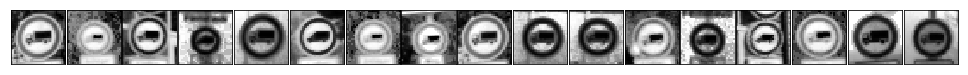

Id: 17, name: No entry


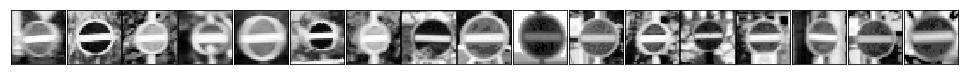

Id: 18, name: General caution


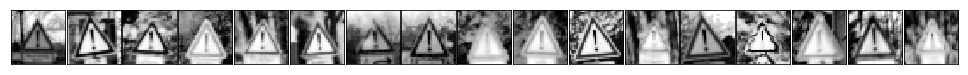

Id: 19, name: Dangerous curve to the left


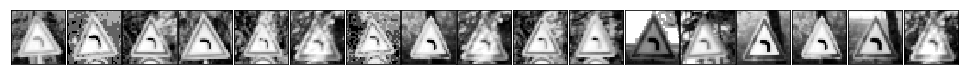

Id: 20, name: Dangerous curve to the right


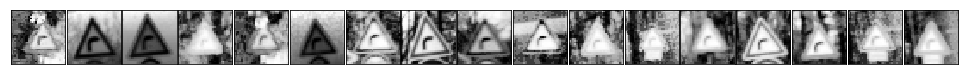

Id: 21, name: Double curve


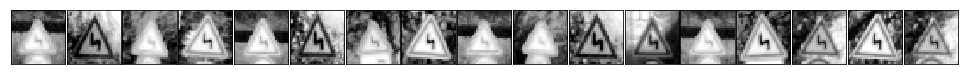

Id: 22, name: Bumpy road


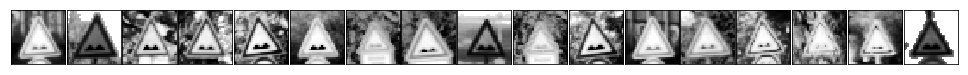

Id: 23, name: Slippery road


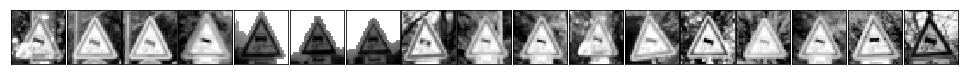

Id: 24, name: Road narrows on the right


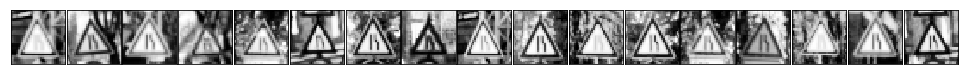

Id: 25, name: Road work


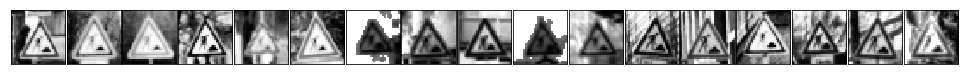

Id: 26, name: Traffic signals


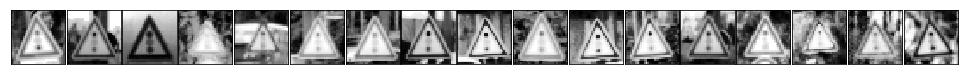

Id: 27, name: Pedestrians


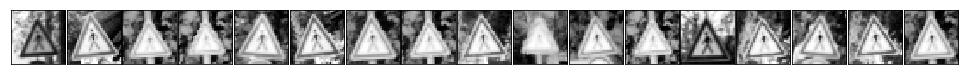

Id: 28, name: Children crossing


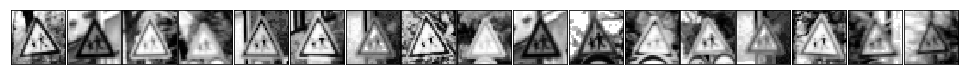

Id: 29, name: Bicycles crossing


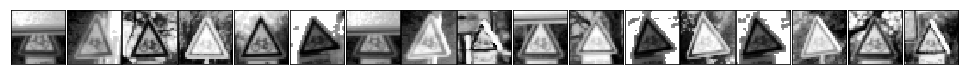

Id: 30, name: Beware of ice/snow


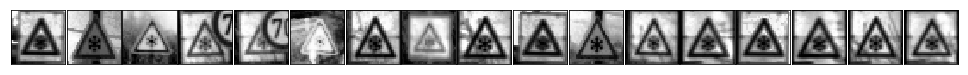

Id: 31, name: Wild animals crossing


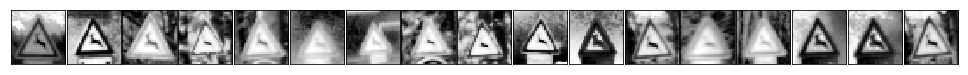

Id: 32, name: End of all speed and passing limits


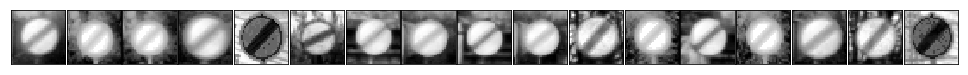

Id: 33, name: Turn right ahead


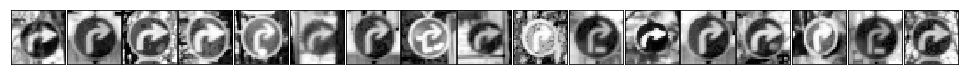

Id: 34, name: Turn left ahead


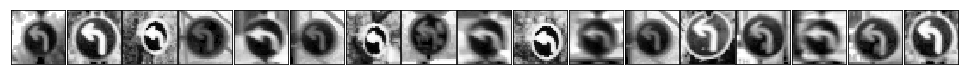

Id: 35, name: Ahead only


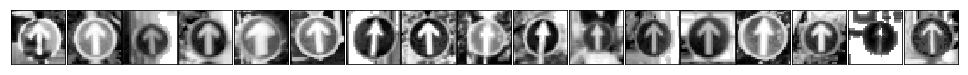

Id: 36, name: Go straight or right


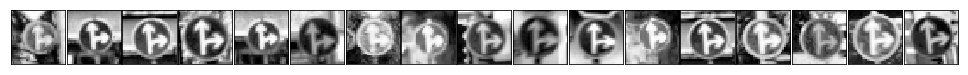

Id: 37, name: Go straight or left


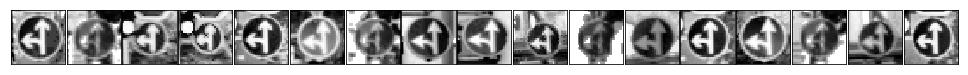

Id: 38, name: Keep right


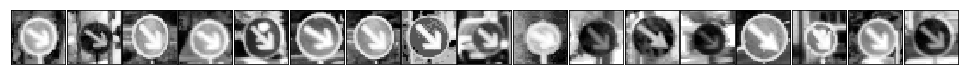

Id: 39, name: Keep left


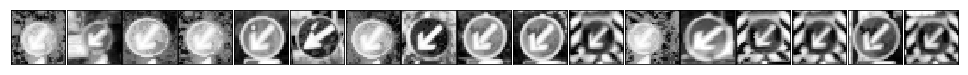

Id: 40, name: Roundabout mandatory


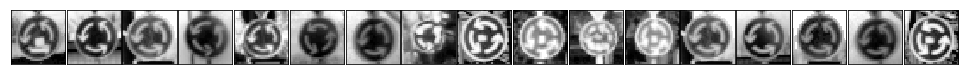

Id: 41, name: End of no passing


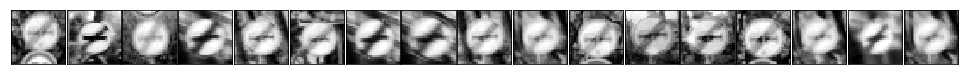

Id: 42, name: End of no passing by vehicles over 3.5 metric tons


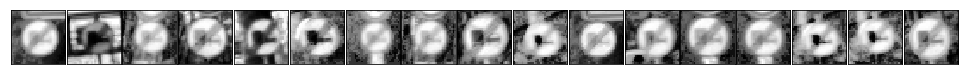

In [29]:
res = print_examples_from_group(X_train, y_train, grayscale = True)

# Neural Network Implementation
### Setup TensorFlow
I stopped on 50 epochs and 128 batch size — with this parameters I get best results for comprehensive time.

In [30]:
EPOCHS = 50
BATCH_SIZE = 128

## Implement LeNet-5
Implement neural network based on the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels (1 in my case because of grayscaling). 

### Architecture
* **Layer 1: Convolutional.** Input = 32x32x1. Output = 28x28x43.
* **Activation.** Relu function.
* **Pooling.** The output shape should be 14x14x43.
* 
* **Layer 2: Convolutional.** Input = 14x14x43. Output = 10x10x80.
* **Activation.** Relu function.
* **Pooling.** The output shape should be 5x5x80.
* 
* **Layer 3: Convolutional.** Input = 5x5x80. Output = 3x3x200.
* **Activation.** Relu function.
* **Pooling.** The output shape should be 2x2x200.
* 
* **Flatten.** Flatten the output shape of the final pooling layer. Output = 1x800
* 
* **Layer 4: Fully Connected.** Input = 800. Output = 120.
* **Activation.** Your choice of activation function.
* 
* **Layer 5: Fully Connected.** Input = 120. Output = 84.
* **Activation.** Your choice of activation function.
* 
* **Layer 6: Fully Connected (Logits).** Input = 84. Output = 43

In [31]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    keep_prob = 0.7
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x43.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 43), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(43))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x43. Output = 14x14x43.
    conv1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Input = 14x14x43 Output = 10x10x80.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 43, 80), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(80))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x80. Output = 5x5x80.
    conv2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 3: Convolutional. Input = 5x5x85. Output = 3x3x200.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(2, 2, 80, 200), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(200))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
    # Activation.
    conv3 = tf.nn.relu(conv3)

    # Pooling. Input = 4x4x200. Output = 2x2x200.
    conv3 = tf.nn.avg_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 4: Convolutional. Output = 10x10x16.
    # conv4_W = tf.Variable(tf.truncated_normal(shape=(2, 2, 200, 800), mean = mu, stddev = sigma))
    # conv4_b = tf.Variable(tf.zeros(200))
    # conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='VALID') + conv4_b
    
    # Activation.
    # conv4 = tf.nn.relu(conv4)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    # conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    
    # Flatten. Input = 2x2x200. Output = 1x800.
    fc0   = flatten(conv3)
    
    # Layer 3: Fully Connected. Input = 800. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(800, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43 (we have 43 classes of signs in the dataset).
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

## Features and Labels
Train LeNet to classify traffic signs data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

In [32]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline
For training pipeline I used 35 epochs and 128 batch size. Incresing of batch size to 256 did not change accuracy of the model, so I decided to stop on this value. I have also trained model with 35 epochs, but after 30 epochs accuracy is normally more or less the same.

I took relu function as suggested in lectuers for activation.

I also took Adam optimizer as optimizer from suggestion in LeNet lab.

The first architecture I used was basic LeNet implementation: it contained 2 convolutional layels and gave me around 86% accuracy. Encreasing its convolutional layels to 3 and changing of size of each level encreased accuracy to around 92%. Increasing to 4 levels did not chage accuracy and I decided to remove 4th level.

I tuned a lot parameters of layels, for example input and output shapes, and came with parameters which satisfy me the best.

I also tried to take average pooling instead of max pooling in my model. I did not see significant effect on the results.

I also added dropout on non convolutional layels with keep probbablility of 0,7. It decreased accuracy a bit on validation and test sets, but increased accuracy on my images. Current version of notebook contains dropout.

In [33]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [34]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model every time when accuracy is improved.

In [35]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    
    max_val_accuracy = 0
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        if validation_accuracy > max_val_accuracy: 
            saver.save(sess, './lenet')
            max_val_accuracy = validation_accuracy

Training...

EPOCH 1 ...
Validation Accuracy = 0.614

EPOCH 2 ...
Validation Accuracy = 0.772

EPOCH 3 ...
Validation Accuracy = 0.836

EPOCH 4 ...
Validation Accuracy = 0.885

EPOCH 5 ...
Validation Accuracy = 0.898

EPOCH 6 ...
Validation Accuracy = 0.909

EPOCH 7 ...
Validation Accuracy = 0.927

EPOCH 8 ...
Validation Accuracy = 0.934

EPOCH 9 ...
Validation Accuracy = 0.939

EPOCH 10 ...
Validation Accuracy = 0.936

EPOCH 11 ...
Validation Accuracy = 0.939

EPOCH 12 ...
Validation Accuracy = 0.936

EPOCH 13 ...
Validation Accuracy = 0.946

EPOCH 14 ...
Validation Accuracy = 0.949

EPOCH 15 ...
Validation Accuracy = 0.961

EPOCH 16 ...
Validation Accuracy = 0.950

EPOCH 17 ...
Validation Accuracy = 0.960

EPOCH 18 ...
Validation Accuracy = 0.952

EPOCH 19 ...
Validation Accuracy = 0.951

EPOCH 20 ...
Validation Accuracy = 0.960

EPOCH 21 ...
Validation Accuracy = 0.947

EPOCH 22 ...
Validation Accuracy = 0.966

EPOCH 23 ...
Validation Accuracy = 0.953

EPOCH 24 ...
Validation Accura

## Evaluate the Model
Evaluate the performance of the model on the test set.

In [36]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.949


# Results analysis
#### Without dropout
I was able to reach around 98% accuracy on the validation set. It shows 95.6% accuracy on test set. It is not the best results and for sure not safe for production usage, so gives a room for improvements (I would suggest to stop near 99.99%). 
#### With dropout
With dropout I reached around 97% accuracy on the validation set and 95% on test set. It is lower than without dropout, but it showed better results on my test images, so I would suggest to perform improvements of preprocessing and then compare results one more time.
#### Improvements 
Improvements could be done in 3 basic places:
1. Model. I played with different amount of network layers, sizes, epoch. In general if we increase amount of epochs changing of other parameters reflects only on how fast network learns, end accuracy does not change significantly. I ended up with an architecture which gives me good results in some suitable time.
2. Images preprocessing. I think this is the first place where improvements could be done. My general proposal for improvements would be better image lightning normalisation and image transformation (see image preprocessing section for details on this proposals).
3. Extending of training set.
In order to see how we need to improve the accuracy we nened to analyse more detaily where the pipeline performs good and where not. 

Evaluation per group


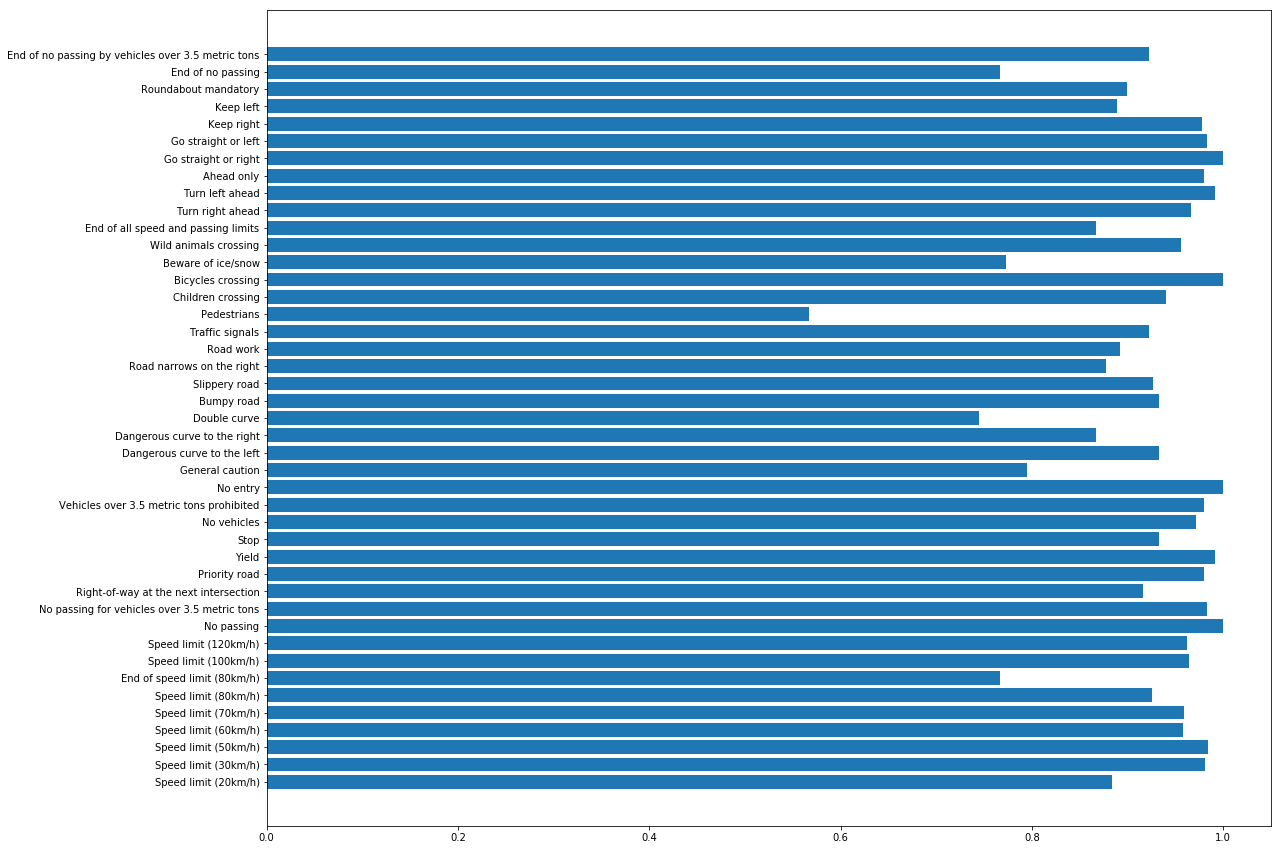

In [37]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    results = []
    for i in range(43):
        sign_ids = np.where(y_test==i)[0]
        observed_images = []
        observed_labels = []
        for id in sign_ids:
            observed_images.append(X_test[id])
            observed_labels.append(i)
        test_accuracy = evaluate(observed_images, observed_labels)
        results.append(test_accuracy)
        
    print("Evaluation per group")
    plt.figure(figsize=(18, 15))
    x_pos = range(43)
    plt.barh(x_pos, results)
    labs=[get_sign_name(j) for j in x_pos]
    plt.yticks(x_pos, labs)
    plt.show()

# Observations

We see that some signs has bad accuracy in recognition. For some of them it is dangerous, for example, "Pedestrians".
Possible solutions how to fix that:
1. Extend train set with this signs.
2. Train model for longer time.
3. If previous did not help, see top 5 softmax probabilities for them, check what are top wrong predictions and try to observe what could be done on preprocessing stage to help neural network distinguish this signs from the top wrong.

One more interesting observation is that there is no correlation between amount of images in the train dataset and accuracy. This may be because some of images are just easier to detect and another are harder.

# Run algorythm on my images
I took images from video with driving in Germany from YouTube and resized them to 32x32. Name of the image represents sign (for evaluation). Video is taken from the car in good conditions, so I do not expect bad results during recognition.

### Load and preprocess images

Bad file .DS_Store
My images test set: 


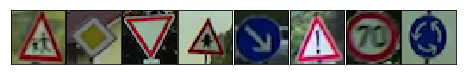

Preprocessed: 


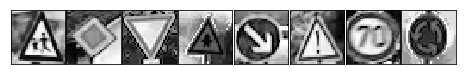

In [38]:
#printing out some stats and plotting
plt.close("all")
my_images_raw = []
my_labels = []
for file in os.listdir("my_image_set/"):
    try: 
        image = mpimg.imread('my_image_set/' + file)
        image = (image * 255).round().astype(np.uint8)
        my_images_raw.append(image) 
        my_labels.append(int(file.split(".")[0]))
    except:
        print("Bad file " + file)
        
my_images = preprocess_images(my_images_raw)    

def print_images(img, cmap = None):
    lane = plt.figure(figsize = (len(img), 1))
    lane.subplots_adjust(hspace = 0, wspace = 0)

    for i in range (len(img)):
        image = img[i]
        a = lane.add_subplot(1, len(img), i + 1, xticks=[], yticks=[])
        a.imshow(image.squeeze(), cmap = cmap)
    plt.show()

print("My images test set: ")
print_images(my_images_raw, cmap = "gray")

print("Preprocessed: ")
print_images(my_images, cmap = "gray")

### Evaluate model on my images

In [39]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(my_images, my_labels)
    print("My images recognition accuracy = {:.3f}".format(test_accuracy))

My images recognition accuracy = 0.875


### Visualise top 5 softmax probabilities for my images

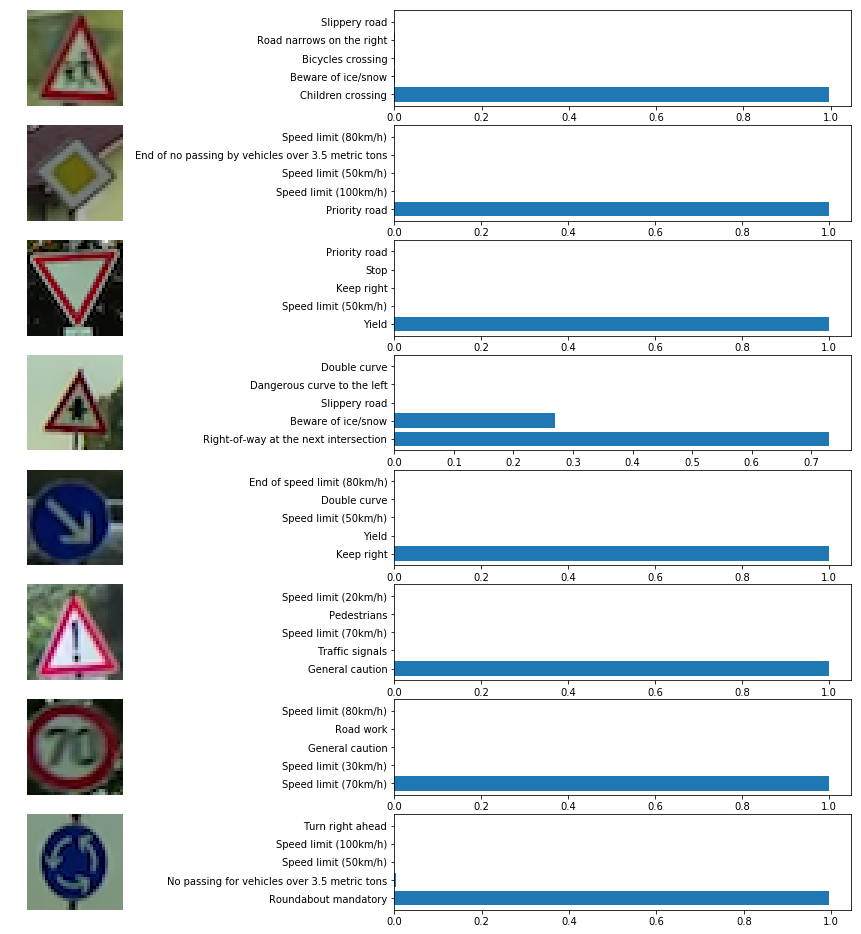

In [40]:
TOP_K = 5

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    my_images_softmax = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=TOP_K), feed_dict={x:my_images})

plt.figure(figsize=(18, 25))

for i in range(len(my_images)):
    plt.subplot(12, 2, 2*i + 1)
    image = my_images_raw[i]
    plt.imshow(image.squeeze(), cmap = "gray") 
    plt.axis('off')
    plt.subplot(12, 2, 2*i + 2)
    plt.barh(np.arange(1, 6, 1), my_images_softmax.values[i, :])
    labs=[get_sign_name(j) for j in my_images_softmax.indices[i]]
    plt.yticks(np.arange(1, 6, 1), labs)
plt.show()
    

### Summary for my images
For my images taken from German Driving video model performs not very good when I ran model without dropout. There are three signs with bad recognition results: 
1. Rign of way at the next intersecrtion gives correct recognition, but only 0.7 probability
2. Speed limit for 70 km/h is recognised as 80 km/h with 100% probability! That is very surprising and is related to the fact that traffic sign is cropped. Once I make it inside the image my model gives better results. It means, that model is sensitive to correct cropping and should be extended with cropped images (or we need to ensure that images will be always correct cropped).
3. Roundabout mandatory is recognied as speed limit 100 km/h. Looking at perocessing image of this and Rign of way at the next intersecrtion sign I see that after preprocessing there is ligt border around the sign. Another signs does not have it. So maybe, it is related to wrong recognition and should be analysed. 

With dropout results on my test set was very good: all signs are recognized correctly and most of them with confidence closed to 1.